# Import libraries

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torchvision.datasets import ImageFolder
import torch.optim as optim
from torch.autograd import Variable
from torch.optim.lr_scheduler import StepLR

torch.manual_seed(0)

import tensorflow as tf

from google.colab import drive
import os
from google.colab import files
from pathlib import Path
from PIL import Image
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import random
from sklearn.metrics import confusion_matrix

# connect to google drive

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Uploade kaggle.json and download data to google drive

In [ ]:
# Import OS for navigation and environment set up
import os
# Check current location, '/content' is the Colab virtual machine
os.getcwd()
# Enable the Kaggle environment, use the path to the directory your Kaggle API JSON is stored in
os.environ['KAGGLE_CONFIG_DIR'] = '/content/gdrive/MyDrive/kaggle'

In [ ]:
#!pip install kaggle

In [ ]:
# Navigate into Drive where you want to store your Kaggle data
os.chdir('/content/gdrive/MyDrive/kaggle')
# Paste and run the copied API command, the data will download to the current directory
# !kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
# Check contents of directory, you should see the .zip file for the competition in your Drive
os.listdir()

['chest-xray-pneumonia.zip', 'chest_xray', '.ipynb_checkpoints', 'saved.pth']

In [ ]:
# Complete path to storage location of the .zip file of data
zip_path = '/content/gdrive/MyDrive/kaggle/chest-xray-pneumonia.zip'
# Check current directory (be sure you're in the directory where Colab operates: '/content')
os.getcwd()
# Copy the .zip file into the present directory
# !cp '{zip_path}' .
# Unzip quietly
# !unzip -q 'chest-xray-pneumonia.zip'
# View the unzipped contents in the virtual machine
os.listdir()

['chest-xray-pneumonia.zip', 'chest_xray', '.ipynb_checkpoints', 'saved.pth']

In [ ]:
batch_size = 128
n_epochs = 15
image_size = 216
prob = 0.7
device = torch.device('cpu')#'cuda:0' if torch.cuda.is_available() else 'cpu')
learning_rate = 0.01
num_workers = 2

# prepare data for train
transform with probability on each image

In [ ]:
class Data_Prepare(object):
  def __init__(self, root_path, set_path, transformation=None):
    self.root_path = root_path
    self.base_transform = transforms.Compose([
                                transforms.Resize((image_size, image_size)),
                                transforms.ToTensor()])
    self.set_path = os.path.join(root_path, set_path)
    self.transformation = transformation
    self.images = []
    for i in list(os.listdir(os.path.join(self.set_path, "NORMAL"))):
      if i[-4:] == 'jpeg':
        self.images.append((i, "NORMAL"))
    for i in list(os.listdir(os.path.join(self.set_path, "PNEUMONIA"))):
      if i[-4:] == 'jpeg':
        self.images.append((i, "PNEUMONIA"))

  def __len__(self):
    return len(self.images)

  def __getitem__(self, idx):
    image_path = os.path.join(self.set_path, self.images[idx][1], self.images[idx][0])
    image = Image.open(image_path).convert('RGB')
    label = 1 if self.images[idx][1] == "PNEUMONIA" else 0
    if self.transformation:
      image = self.transformation(image)
    image = self.base_transform(image)
    return image, label

In [ ]:

transform = transforms.RandomApply(torch.nn.ModuleList([
                                                        transforms.RandomHorizontalFlip(p = prob),
                                                        transforms.RandomPerspective(distortion_scale = 0.1, p = prob),
                                                        transforms.RandomRotation(degrees = (-10, 10)),
                                                        transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5))
                                                        ]), p = 0.5)
"""

transform = torch.nn.Sequential(
                                transforms.RandomApply([transforms.RandomHorizontalFlip()], p = prob),
                                transforms.RandomApply([transforms.RandomRotation(degrees=15)], p = prob),
                                transforms.RandomApply([transforms.ColorJitter(brightness=.5, hue=.3)], p = prob))
"""
base_transform = transforms.Compose([
                                transforms.Resize((image_size, image_size)),
                                transforms.ToTensor()])

# create train, test and valid datasets using the ImageDataset() class and three transforms

In [ ]:
train_data = Data_Prepare("chest_xray/chest_xray", "train", transformation = transform)
test_data = dsets.ImageFolder('chest_xray/test', transform = base_transform)
validation_data = dsets.ImageFolder('chest_xray/val', transform = base_transform)

# create dataloader of three datasets

In [ ]:
train = torch.utils.data.DataLoader(train_data, batch_size = batch_size, num_workers = num_workers, shuffle = True)
val = torch.utils.data.DataLoader(validation_data, batch_size = batch_size, num_workers = num_workers, shuffle = True)
test = torch.utils.data.DataLoader(test_data, batch_size = batch_size, num_workers = num_workers, shuffle = False)

# Function for show images in dataset

In [ ]:
def show_img(data):
  fig = plt.figure(figsize=(40,10))
  for i, (images, labels) in enumerate(data):
    for j, (image, label) in enumerate(zip(images,labels)):
      if j == 30:
        break
      image = transforms.ToPILImage()(image)
      plt.subplot(3, 10, j + 1)  # Adjust subplot layout
      plt.imshow(image)
      plt.title('normal' if label == 0 else 'pneumonia')  # Explicit label
    if i > 0:
      break
  plt.tight_layout()  # Improve layout between subplots
  plt.show()

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


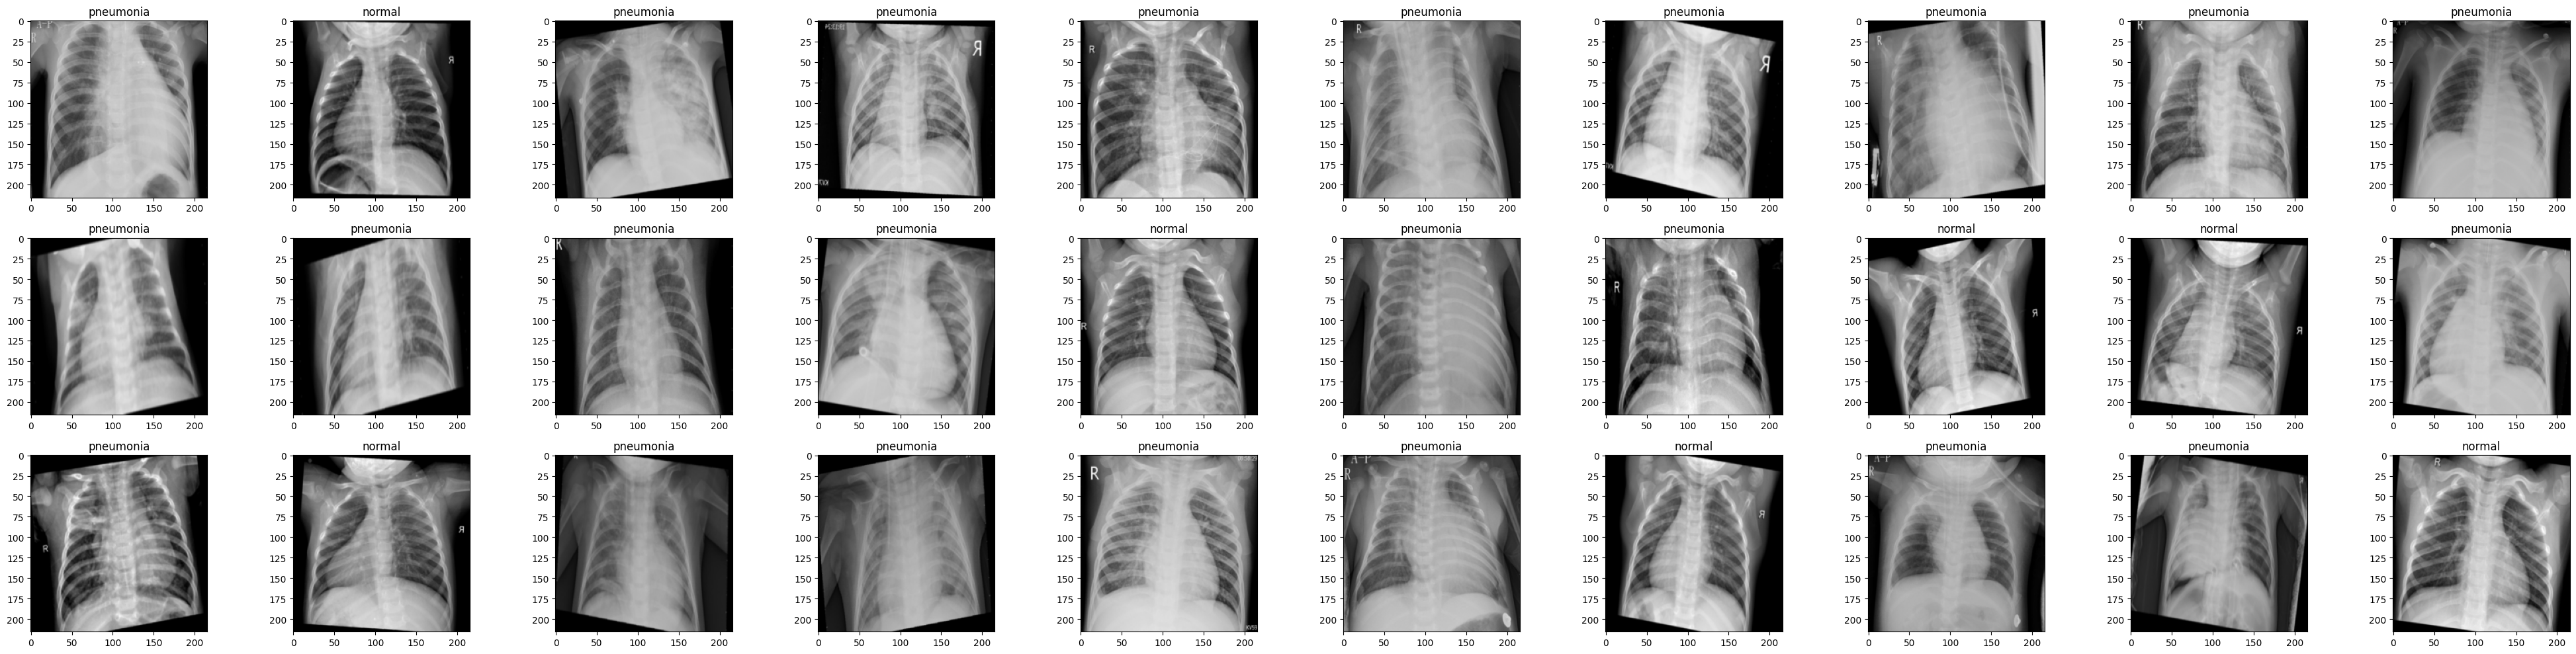

In [ ]:
show_img(train)

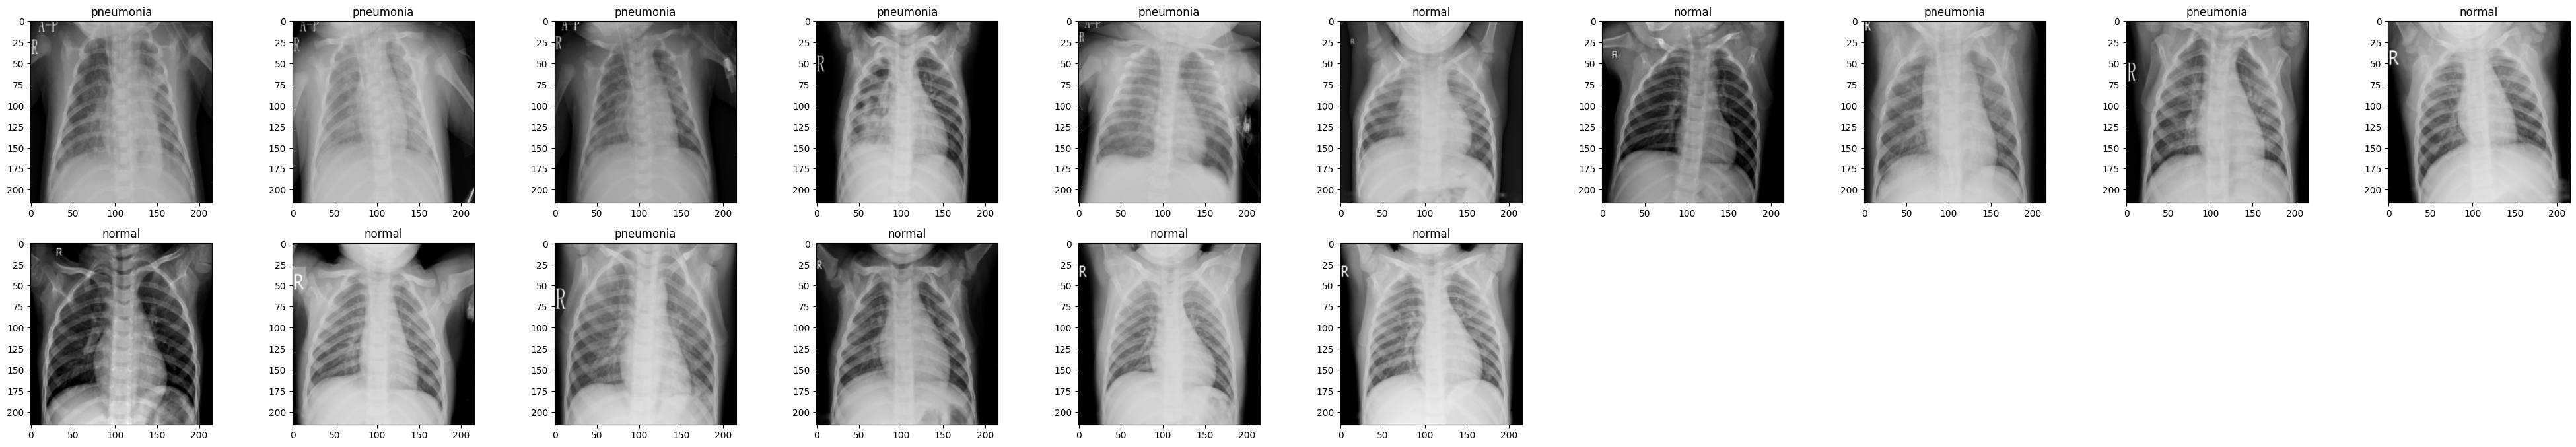

In [ ]:
show_img(val)

# Creating a neural network
It has three residual block, each with two convolutional layers.
At first we have a residual class for blocks
that takes the size of the input,output,kernel and downsample then Makes two convolutional layers. In forward
We enter the input into this network and also implement skip-connection.Then on
We create a class of three residual blocks that size of
Their output is 16, 32 and 64, respectively,Inputs of this class are dropout and a list of paddings. Finally, we have a fully connected layer whose input size is obtained from the output size of the last residual block. The output size of this
Layer is 2 because we have two classes. In the make_layer function if the input and output sizes are not the same
Apply downsampling. Before passing to fc, be sure to use the fc's input shape in two dimensions using the view.

In [ ]:
class ResBlock(nn.Module):
  def __init__(self, in_channels, mid_channels, out_channels, kernel_size, paddings, down_sampling):
    super(ResBlock, self).__init__()
    self.conv1 = nn.Conv2d(in_channels, mid_channels, kernel_size = kernel_size, stride = 3, padding = paddings[0])
    self.batch_norm1 = nn.BatchNorm2d(mid_channels)
    self.conv2 = nn.Conv2d(mid_channels, out_channels, kernel_size = kernel_size, stride = 1, padding = paddings[1])
    self.batch_norm2 = nn.BatchNorm2d(out_channels)
    self.relu = nn.ReLU()
    self.down_sampling = down_sampling

  def forward(self, x):
    residual = x.clone()
    residual = self.down_sampling(residual)
    x = self.conv1(x)
    x = self.batch_norm1(x)
    x = self.relu(x)
    x = self.conv2(x)
    x = self.batch_norm2(x)
    x += residual
    x = self.relu(x)
    return x


class ResNet(nn.Module):
  def __init__(self, dropout=True):
    super(ResNet, self).__init__()
    self.dropout = nn.Dropout(0.4) if dropout == True else None

    down_sampling1 = nn.Sequential(nn.Conv2d(3, 12, kernel_size = 7, stride = 3, padding = 2),
                                   nn.BatchNorm2d(12))

    self.block1 = self.make_block(3, 6, 12, 7, [2, 3], down_sampling1)

    down_sampling2 = nn.Sequential(nn.Conv2d(12, 24, kernel_size = 5, stride = 3, padding = 1),
                                   nn.BatchNorm2d(24))

    self.block2 = self.make_block(12, 16, 24, 5, [1, 2], down_sampling2)

    down_sampling3 = nn.Sequential(nn.Conv2d(24, 16, kernel_size = 3, stride = 3),
                                   nn.BatchNorm2d(16))

    self.block3 = self.make_block(24, 20, 16, 3, [0, 1], down_sampling3)

    self.fc = nn.Linear(1024 ,2)

    self.softmax = nn.Softmax(dim = 1)
    self.flatten = nn.Flatten(1)

  def make_block(self, in_channels, mid_channels, out_channels, kernel_size, paddings, down_sampling):
    layers = []
    layers.append(ResBlock(in_channels, mid_channels, out_channels, kernel_size, paddings, down_sampling))
    return nn.Sequential(*layers)

  def forward(self, x):
    x = self.block1(x)
    x = self.block2(x)
    x = self.block3(x)
    x = x.reshape(x.shape[0], -1)
    #x = self.flatten(x)
    if self.dropout:
      x = self.dropout(x)
    x = self.fc(x)
    #x = self.softmax(x)
    x = F.log_softmax(x, dim=-1)
    return x


In [ ]:
resnet = ResNet()

In [ ]:
print(resnet)

ResNet(
  (dropout): Dropout(p=0.4, inplace=False)
  (block1): Sequential(
    (0): ResBlock(
      (conv1): Conv2d(3, 6, kernel_size=(7, 7), stride=(3, 3), padding=(2, 2))
      (batch_norm1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(6, 12, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
      (batch_norm2): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (down_sampling): Sequential(
        (0): Conv2d(3, 12, kernel_size=(7, 7), stride=(3, 3), padding=(2, 2))
        (1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
  )
  (block2): Sequential(
    (0): ResBlock(
      (conv1): Conv2d(12, 16, kernel_size=(5, 5), stride=(3, 3), padding=(1, 1))
      (batch_norm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 24, kernel_size=(5, 5), stride=(1, 1), padding=(2,

# Train the model
In each epoch, first the train data
We get batch of data put it to the model and calculate the loss, and use loss.backward () to Go back to the beginning of the network and update the optimizer.print loss in every epoch. In every 5 epochs we display the loss value on the valid data and plot the train loss change diagram. In all 4 epochs using the update_lr function
to update the value of learning_rate if the value of the loss on the data was less valid We update min_valid_loss and save the model.

In [ ]:
def train_net(model, train, validation, device, num_epoch, lr):
  model.to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  criterion = nn.CrossEntropyLoss()
  min_valid_loss = np.inf
  train_losses_list = []
  valid_losses_list = []
  scheduler = StepLR(optimizer, step_size = 1, gamma = 0.9)
  eps = []

  for epoch in range(n_epochs):
    model.train()
    train_loss = 0
    eps.append(epoch+1)

    for iter , (images, labels) in enumerate(train):
      images, labels = images.to(device), labels.to(device)
      optimizer.zero_grad()
      outputs = model(images)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      train_loss += loss.item() * images.shape[0]

      if iter % 10 == 0:
        is_training = model.training
        validation_loss = 0
        model.eval()
        for val_data, val_labels in validation:
          val_data, val_labels = val_data.to(device), val_labels.to(device)
          val_output = model(val_data.float())
          val_loss = criterion(val_output, val_labels)
          validation_loss += val_loss.item() * val_data.shape[0]

        validation_loss = validation_loss/len(validation.sampler)
        valid_losses_list.append(validation_loss)

        if validation_loss <= min_valid_loss:
          print("validation loss is decreasing: ({:.6f} --> {:.6f})".format(min_valid_loss, validation_loss))
          min_valid_loss = validation_loss
          print("The model is saving...")
          torch.save(model.state_dict(), 'saved.pth')
          print("Model saved successfully.")
        model.train(mode = is_training)

    train_loss = train_loss/len(train.sampler)
    train_losses_list.append(train_loss)
    print("epoch:", (epoch+1), "------Train loss:", train_loss, "------------LR:", scheduler.get_lr())

    if (epoch + 1) % 5 == 0:
      scheduler.step()

  plt.plot(eps, train_losses_list)
  plt.title("train loss")
  plt.xlabel("num of epoch")
  plt.ylabel("loss")
  plt.show()



# accuracy
Here we load the saved model and test it on the test data
 and print the values ​​of accuracy

In [ ]:
def accuracy(model, test):
  model.eval()
  with torch.no_grad():
    test_loss = 0
    correct = 0
    total = 0
    for data, labels in test:
      data, labels = data.to(device), labels.to(device)
      outputs = model(data.float())
      _, predict = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predict == labels).sum().item()
      #loss =  nn.CrossEntropyLoss(outputs, labels)
      #test_loss += loss.item() * data.size(0)
  print("Accuracy on test data: " + str(correct/total))

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


validation loss is decreasing: (inf --> 1.096931)
The model is saving...
Model saved successfully.
epoch: 1 ------Train loss: 0.5676759056335577 ------------LR: [0.01]


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:402: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


validation loss is decreasing: (1.096931 --> 1.044640)
The model is saving...
Model saved successfully.
validation loss is decreasing: (1.044640 --> 0.831560)
The model is saving...
Model saved successfully.
validation loss is decreasing: (0.831560 --> 0.728152)
The model is saving...
Model saved successfully.
epoch: 2 ------Train loss: 0.21761886437246405 ------------LR: [0.01]
validation loss is decreasing: (0.728152 --> 0.389627)
The model is saving...
Model saved successfully.
epoch: 3 ------Train loss: 0.17170023698748255 ------------LR: [0.01]
epoch: 4 ------Train loss: 0.1374292487929935 ------------LR: [0.01]
epoch: 5 ------Train loss: 0.13372468687822484 ------------LR: [0.01]
epoch: 6 ------Train loss: 0.12146808266456872 ------------LR: [0.008100000000000001]
epoch: 7 ------Train loss: 0.11342197176686093 ------------LR: [0.008100000000000001]
epoch: 8 ------Train loss: 0.11310046668981481 ------------LR: [0.008100000000000001]
epoch: 9 ------Train loss: 0.09524208718647986 

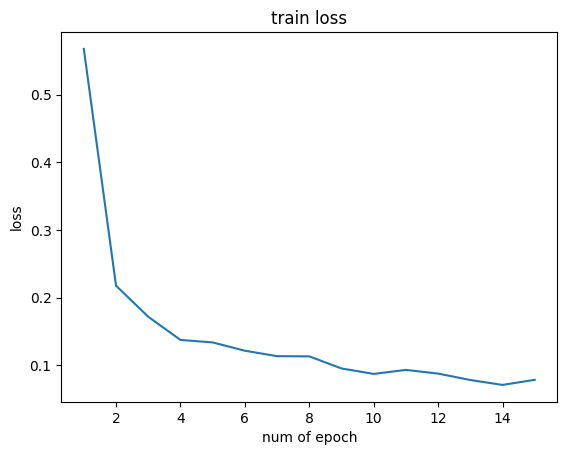

In [ ]:
train_net(resnet, train, val, device, n_epochs, learning_rate)

In [ ]:
model = ResNet(dropout=True)
model.load_state_dict(torch.load('/content/gdrive/MyDrive/kaggle/saved.pth', map_location=torch.device('cpu')))
model.to(device)
accuracy(model, test)

Accuracy on test data: 0.7900641025641025
